In [1]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Denoising Diffusion Probabilistic Model on 3D data

This tutorial illustrates how to use MONAI for training a denoising diffusion probabilistic model (DDPM)[1] to create synthetic 3D images.

[1] - [Ho et al. "Denoising Diffusion Probabilistic Models"](https://arxiv.org/abs/2006.11239)


## Setup environment

In [2]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [48]:
import os
import tempfile
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.transforms import AddChanneld, CenterSpatialCropd, Compose, Lambdad, LoadImaged, Resized, ScaleIntensityd
from monai.utils import set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset, random_split
import scipy
import io
import random
import math
import pandas as pd
from generative.networks.schedulers import DDPMScheduler, DDIMScheduler
import numpy as np
import SimpleITK as sitk
import torchio as tio
sitk.ProcessObject.SetGlobalDefaultThreader("Platform")
from multiprocessing import Manager

from typing import Optional

import warnings
warnings.filterwarnings('ignore')

# Set the manualSeed, random seed, and device
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# It's recommended to set the global deterministic behavior of some libraries.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set the default number of threads for SimpleITK.
sitk.ProcessObject.SetGlobalDefaultThreader("Platform")

# Set the global behavior of SimpleITK to use the Platform multithreading.
# This is especially useful when using SimpleITK with multi-core systems.
sitk.ProcessObject.SetGlobalDefaultThreader("Platform")


True

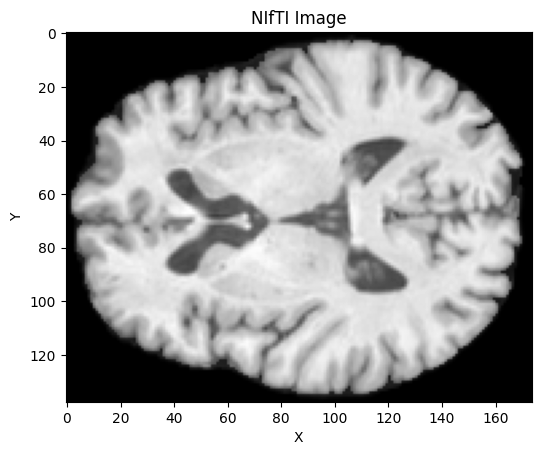

In [49]:

import nibabel as nib
import matplotlib.pyplot as plt

def plot_nii_image(nii_file_path):
    # Load the NIfTI image
    img = nib.load(nii_file_path)

    # Get the image data as a numpy array
    img_data = img.get_fdata()

    # Plot the middle slice of the image (you can change the slice number if needed)
    middle_slice = img_data.shape[2] // 2
    plt.imshow(img_data[:, :, middle_slice], cmap='gray')

    # Add title and labels
    plt.title('NIfTI Image')
    plt.xlabel('X')
    plt.ylabel('Y')

    # Show the plot
    plt.show()

# Replace 'path_to_your_nii_file.nii' with the actual path to your NIfTI image file
nii_file_path = '/scratch1/akrami/Data_train/Train/ixi/t1/IXI167-HH-1569_t1.nii.gz'
plot_nii_image(nii_file_path)


In [50]:
config = {
    'batch_size': 2,
    'imgDimResize':(160,192,160),
    'imgDimPad': (208, 256, 208),
    'spatialDims': '3D',
    'unisotropic_sampling': True, 
    'perc_low': 1, 
    'perc_high': 99,
    'rescaleFactor':4,
    'base_path': '/scratch1/akrami/Latest_Data/Data',
}


In [51]:
def Train(csv,cfg,preload=True):
    subjects = []
    base_path = cfg.get('base_path',None)
    h, w, d = tuple(cfg.get('imgDimResize',(160,192,160)))
    for _, sub in csv.iterrows():
       # print(sub.img_path)
        subject_dict = {
            'vol' : tio.ScalarImage(sub.img_path, reader=sitk_reader), 
            'age' : sub.age,
            'ID' : sub.img_name,
            'path' : sub.img_path
        }

        if sub.mask_path != None: # if we have masks
            subject_dict['mask'] = tio.LabelMap(sub.mask_path,reader=sitk_reader)
        subject = tio.Subject(subject_dict)
        subjects.append(subject)
    
    if preload: 
        manager = Manager()
        cache = DatasetCache(manager)
        ds = tio.SubjectsDataset(subjects, transform = get_transform(cfg))
        ds = preload_wrapper(ds, cache, augment = get_augment(cfg))
    else: 
        ds = tio.SubjectsDataset(subjects, transform = tio.Compose([get_transform(cfg),get_augment(cfg)]))
        
    if cfg.get('spatialDims') == '2D':
        slice_ind = cfg.get('startslice',None) 
        seq_slices = cfg.get('sequentialslices',None) 
        ds = vol2slice(ds,cfg,slice=slice_ind,seq_slices=seq_slices)
    return ds

def sitk_reader(path):
                
    image_nii = sitk.ReadImage(str(path), sitk.sitkFloat32)
    vol = sitk.GetArrayFromImage(image_nii).transpose(2,1,0)
    return vol, None


def get_transform(cfg): # only transforms that are applied once before preloading
    exclude_from_resampling = None
    h, w, d = tuple(cfg.get('imgDimResize',(160,192,160)))
    if cfg.get('unisotropic_sampling',True):
        preprocess = tio.Compose([
        tio.CropOrPad((h,w,d),padding_mode=0),
        tio.RescaleIntensity((0, 1),percentiles=(cfg.get('perc_low',1),cfg.get('perc_high',99)),masking_method='mask'),
        tio.Resample(cfg.get('rescaleFactor',3.0),image_interpolation='bspline',exclude=exclude_from_resampling),#,exclude=['vol_orig','mask_orig','seg_orig']), # we do not want to resize *_orig volumes
        ])

    else: 
        preprocess = tio.Compose([
                tio.RescaleIntensity((0, 1),percentiles=(cfg.get('perc_low',1),cfg.get('perc_high',99))),
                tio.Resample(cfg.get('rescaleFactor',3.0),image_interpolation='bspline',exclude=exclude_from_resampling),#,exclude=['vol_orig','mask_orig','seg_orig']), # we do not want to resize *_orig volumes
            ])


    return preprocess


class DatasetCache(object):
    def __init__(self, manager, use_cache=True):
        self.use_cache = use_cache
        self.manager = manager
        self._dict = manager.dict()

    def is_cached(self, key):
        if not self.use_cache:
            return False
        return str(key) in self._dict

    def reset(self):
        self._dict.clear()

    def get(self, key):
        if not self.use_cache:
            raise AttributeError('Data caching is disabled and get funciton is unavailable! Check your config.')
        return self._dict[str(key)]

    def cache(self, key, subject):
        # only store if full data in memory is enabled
        if not self.use_cache:
            return
        # only store if not already cached
        if str(key) in self._dict:
            return
        self._dict[str(key)] = (subject)

class preload_wrapper(Dataset):
    def __init__(self,ds,cache,augment=None):
            self.cache = cache
            self.ds = ds
            self.augment = augment
    def reset_memory(self):
        self.cache.reset()
    def __len__(self):
            return len(self.ds)
            
    def __getitem__(self, index):
        if self.cache.is_cached(index) :
            subject = self.cache.get(index)
        else:
            subject = self.ds.__getitem__(index)
            self.cache.cache(index, subject)
        if self.augment:
            subject = self.augment(subject)
        return subject
    
class vol2slice(Dataset):
    def __init__(self,ds,cfg,onlyBrain=False,slice=None,seq_slices=None):
            self.ds = ds
            self.onlyBrain = onlyBrain
            self.slice = slice
            self.seq_slices = seq_slices
            self.counter = 0 
            self.ind = None
            self.cfg = cfg

    def __len__(self):
            return len(self.ds)
            
    def __getitem__(self, index):
        subject = self.ds.__getitem__(index)
        
        #Commenting the next few lines to introduce a simple masking operation
#         if self.onlyBrain:
#             start_ind = None
#             for i in range(subject['vol'].data.shape[-1]):
#                 if subject['mask'].data[0,:,:,i].any() and start_ind is None: # only do this once
#                     start_ind = i 
#                 if not subject['mask'].data[0,:,:,i].any() and start_ind is not None: # only do this when start_ind is set
#                     stop_ind = i 
#             low = start_ind
#             high = stop_ind
#         else: 
#             low = 0
#             high = subject['vol'].data.shape[-1]
#         if self.slice is not None:
#             self.ind = self.slice
#             if self.seq_slices is not None:
#                 low = self.ind
#                 high = self.ind + self.seq_slices
#                 self.ind = torch.randint(low,high,size=[1])
#         else:
#             if self.cfg.get('unique_slice',False): # if all slices in one batch need to be at the same location
#                 if self.counter % self.cfg.batch_size == 0 or self.ind is None: # only change the index when changing to new batch
#                     self.ind = torch.randint(low,high,size=[1])
#                 self.counter = self.counter +1
#             else: 
#                 self.ind = torch.randint(low,high,size=[1])

#         subject['ind'] = self.ind

#         subject['vol'].data = subject['vol'].data[...,self.ind]
#         subject['mask'].data = subject['mask'].data[...,self.ind]


        subject['vol'].data = subject['vol'].data.permute(0,3, 2, 1)
    
#         #msk_normal = ~np.all(subject['vol'].data.numpy()[0] == 0,axis=(1,2)) # Remove empty planes (Replacing this line of code to include slices that have significant prain volume in them (more than 15% of the image is brain))
        
#         msk_normal = (np.count_nonzero(subject['vol'].data.numpy()[0],axis=(1,2))/(subject['vol'].data.numpy()[0].shape[1]*subject['vol'].data.numpy()[0].shape[2]))>=0.15
        
#         choices = np.arange(len(msk_normal))[msk_normal]
        
#         sample_idx = np.array(random.choices(choices,k = 1))
        
#         subject['vol'].data = subject['vol'].data[0:2, sample_idx, ...]

        return subject

def get_augment(cfg): # augmentations that may change every epoch
    augmentations = []

    # individual augmentations
    augment = tio.Compose(augmentations)
    return augment

In [52]:
imgpath = {}
csvpath_train = '/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/IXI_train_fold0.csv'
pathBase = '/scratch1/akrami/Data_train'
csvpath_val = '/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/IXI_val_fold0.csv'
csvpath_test = '/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/Brats21_test.csv'
var_csv = {}
states = ['train','val','test']
var_csv['train'] = pd.read_csv(csvpath_train)
var_csv['val'] = pd.read_csv(csvpath_val)
var_csv['test'] = pd.read_csv(csvpath_test)
# if cfg.mode == 't2':
#     keep_t2 = pd.read_csv(cfg.path.IXI.keep_t2) # only keep t2 images that have a t1 counterpart

for state in states:
    var_csv[state]['settype'] = state
    var_csv[state]['img_path'] = pathBase  + var_csv[state]['img_path']
    var_csv[state]['mask_path'] = pathBase  + var_csv[state]['mask_path']
    var_csv[state]['seg_path'] = None

    # if cfg.mode == 't2': 
    #     var_csv[state] =var_csv[state][var_csv[state].img_name.isin(keep_t2['0'].str.replace('t2','t1'))]
    #     var_csv[state]['img_path'] = var_csv[state]['img_path'].str.replace('t1','t2')

In [53]:
data_train = Train(var_csv['train'],config) 
data_val = Train(var_csv['val'],config)                
data_test = Train(var_csv['test'],config)

In [54]:
#data_train = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/IXI_train_fold0.csv', converters={'img_path': pd.eval}), config)
train_loader = DataLoader(data_train, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=1)

#data_val = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/IXI_val_fold0.csv', converters={'img_path': pd.eval}), config)
val_loader = DataLoader(data_train, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=1)

#data_test = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/Brats21_test.csv', converters={'img_path': pd.eval}), config)
test_loader = DataLoader(data_train, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=1)

In [55]:
s = next(iter(train_loader))

In [56]:
print(s.keys())
print(s['age'])
print(s['vol']['data'].size())

dict_keys(['vol', 'age', 'ID', 'path', 'mask'])
tensor([24.3100, 68.4800], dtype=torch.float64)
torch.Size([2, 1, 40, 48, 40])


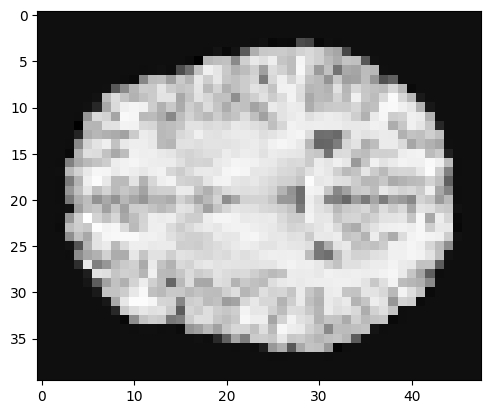

In [57]:
image_array = s['vol']['data'][0][0][:,:,20].squeeze().cpu().numpy()
plt.imshow(image_array, cmap='gray');

## Setup data directory

You can specify a directory with the MONAI_DATA_DIRECTORY environment variable.

This allows you to save results and reuse downloads.

If not specified a temporary directory will be used.

In [58]:
root_dir = '/project/ajoshi_27/akrami/monai3D/GenerativeModels/data'

## Set deterministic training for reproducibility

In [59]:
set_determinism(42)

## Setup Decathlon Dataset and training and validation data loaders

In this tutorial, we will use the 3D T1 weighted brain images from the [2016 and 2017 Brain Tumor Segmentation (BraTS) challenges](https://www.med.upenn.edu/sbia/brats2017/data.html). This dataset can be easily downloaded using the [DecathlonDataset](https://docs.monai.io/en/stable/apps.html#monai.apps.DecathlonDataset) from MONAI (`task="Task01_BrainTumour"`). To load the training and validation images, we are using the `data_transform` transformations that are responsible for the following:

1. `LoadImaged`:  Loads the brain images from files.
2. `Lambdad`: Choose channel 1 of the image, which is the T1-weighted image.
3. `AddChanneld`: Add the channel dimension of the input data.
4. `ScaleIntensityd`: Apply a min-max scaling in the intensity values of each image to be in the `[0, 1]` range.
5. `CenterSpatialCropd`: Crop the background of the images using a roi of size `[160, 200, 155]`.
6. `Resized`: Resize the images to a volume with size `[32, 40, 32]`.

For the data loader, we are using mini-batches of 8 images, which consumes about 21GB of GPU memory during training. Please, reduce this value to run on smaller GPUs.

In [60]:
# data_transform = Compose(
#     [
#         LoadImaged(keys=["image"]),
#         Lambdad(keys="image", func=lambda x: x[:, :, :, 1]),
#         AddChanneld(keys=["image"]),
#         ScaleIntensityd(keys=["image"]),
#         CenterSpatialCropd(keys=["image"], roi_size=[160, 200, 155]),
#         Resized(keys=["image"], spatial_size=(32, 40, 32)),
#     ]
# )

In [61]:
# train_ds = DecathlonDataset(
#     root_dir=root_dir, task="Task01_BrainTumour", transform=data_transform, section="training", download=True
# )

# train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=8, persistent_workers=True)

# val_ds = DecathlonDataset(
#     root_dir=root_dir, task="Task01_BrainTumour", transform=data_transform, section="validation", download=True
# )

# val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=8, persistent_workers=True)

### Visualization of the training images

In [62]:
# plt.subplots(1, 4, figsize=(10, 6))
# for i in range(4):
#     plt.subplot(1, 4, i + 1)
#     plt.imshow(train_ds[i * 20]["image"][0, :, :, 15].detach().cpu(), vmin=0, vmax=1, cmap="gray")
#     plt.axis("off")
# plt.tight_layout()
# plt.show()
# print(train_ds[i * 20]["image"].shape)

### Define network, scheduler, optimizer, and inferer

We will use a DDPM in this example; for that, we need to define a `DiffusionModelUNet` network that will have as input the noisy images and the values for the timestep `t`, and it will predict the noise that is present in the image.

In this example, we have a network with three levels (with 256, 256, and 512 channels in each). In every level, we will have two residual blocks, and only the last one will have an attention block with a single attention head (with 512 channels).

In [63]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    num_channels=[256, 256, 512],
    attention_levels=[False, False, True],
    num_head_channels=[0, 0, 512],
    num_res_blocks=2,
)
model.to(device)

DiffusionModelUNet(
  (conv_in): Convolution(
    (conv): Conv3d(1, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (time_embed): Sequential(
    (0): Linear(in_features=256, out_features=1024, bias=True)
    (1): SiLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock(
      (resnets): ModuleList(
        (0): ResnetBlock(
          (norm1): GroupNorm(32, 256, eps=1e-06, affine=True)
          (nonlinearity): SiLU()
          (conv1): Convolution(
            (conv): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          )
          (time_emb_proj): Linear(in_features=1024, out_features=256, bias=True)
          (norm2): GroupNorm(32, 256, eps=1e-06, affine=True)
          (conv2): Convolution(
            (conv): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          )
          (skip_connection): Identity()
        )
        (1): R

Together with our U-net, we need to define the Noise Scheduler for the diffusion model. This scheduler is responsible for defining the amount of noise that should be added in each timestep `t` of the diffusion model's Markov chain. Besides that, it has the operations to perform the reverse process, which will remove the noise of the images (a.k.a. denoising process). In this case, we are using a `DDPMScheduler`. Here we are using 1000 timesteps and a `scaled_linear` profile for the beta values (proposed in [Rombach et al. "High-Resolution Image Synthesis with Latent Diffusion Models"](https://arxiv.org/abs/2112.10752)). This profile had better results than the `linear, proposed in the original DDPM's paper. In `beta_start` and `beta_end`, we define the limits for the beta values. These are important to determine how accentuated is the addition of noise in the image.

In [64]:
scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="scaled_linear_beta", beta_start=0.0005, beta_end=0.0195)

Text(0, 0.5, 'alpha cumprod')

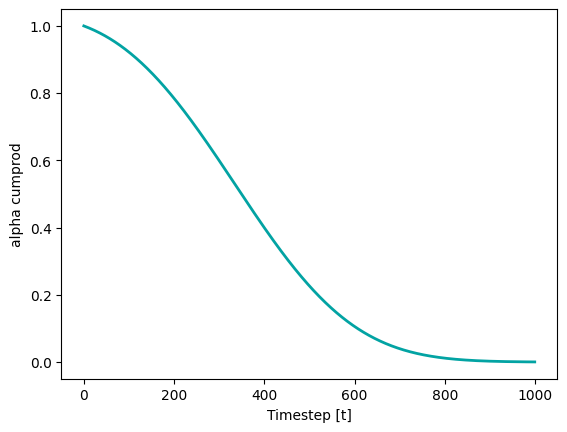

In [65]:
plt.plot(scheduler.alphas_cumprod.cpu(), color=(2 / 255, 163 / 255, 163 / 255), linewidth=2)
plt.xlabel("Timestep [t]")
plt.ylabel("alpha cumprod")

Finally, we define the Inferer, which contains functions that will help during the training and sampling of the model, and the optimizer.

In [66]:
inferer = DiffusionInferer(scheduler)

optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-5)

## Model training

In this part, we will train the diffusion model to predict the noise added to the images. For this, we are using an MSE loss between the prediction and the original noise. During the training, we are also sampling brain images to evaluate the evolution of the model. In this training, we use Automatic Mixed Precision to save memory and speed up the training.

In [ ]:
n_epochs =150
val_interval = 25
epoch_loss_list = []
val_epoch_loss_list = []

scaler = GradScaler()
total_start = time.time()
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
       # images = batch["image"].to(device)
        images = batch['vol']['data'].to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            # Generate random noise
            noise = torch.randn_like(images).to(device)

            # Create timesteps
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long()

            # Get model prediction
            noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)

            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_loss_list.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        for step, batch in enumerate(val_loader):
            images = batch['vol']['data'].to(device)
            noise = torch.randn_like(images).to(device)
            with torch.no_grad():
                with autocast(enabled=True):
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                    ).long()

                    # Get model prediction
                    noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                    val_loss = F.mse_loss(noise_pred.float(), noise.float())

            val_epoch_loss += val_loss.item()
            progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
        val_epoch_loss_list.append(val_epoch_loss / (step + 1))

        # Sampling image during training
        #80, 96, 80
        image = torch.randn((1, 1, 40, 48, 40))
        image = image.to(device)
        scheduler.set_timesteps(num_inference_steps=1000)
        with autocast(enabled=True):
            image = inferer.sample(input_noise=image, diffusion_model=model, scheduler=scheduler)

        plt.figure(figsize=(2, 2))
        plt.imshow(image[0, 0, :, :, 15].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

Epoch 5:   8%|▋        | 16/194 [00:08<01:35,  1.87it/s, loss=0.00889]

### Learning curves

In [ ]:
plt.style.use("seaborn-v0_8")
plt.title("Learning Curves", fontsize=20)
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_loss_list, color="C0", linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)),
    val_epoch_loss_list,
    color="C1",
    linewidth=2.0,
    label="Validation",
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

## Sampling Brain Image

In order to sample the brain images, we need to pass the model an image containing just noise and use it to remove the noise of the image iteratively. For that, we will use the `.sample()` function of the `inferer`.

In [ ]:
model.eval()
noise = torch.randn((1, 1, 32, 40, 32))
noise = noise.to(device)
scheduler.set_timesteps(num_inference_steps=1000)
image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

In [ ]:
plt.style.use("default")
plotting_image_0 = np.concatenate([image[0, 0, :, :, 15].cpu(), np.flipud(image[0, 0, :, 20, :].cpu().T)], axis=1)
plotting_image_1 = np.concatenate([np.flipud(image[0, 0, 15, :, :].cpu().T), np.zeros((32, 32))], axis=1)
plt.imshow(np.concatenate([plotting_image_0, plotting_image_1], axis=0), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

### Sampling with Denoising Diffusion Implicit Model Scheduler

Recent papers have proposed different ways to improve the sampling speed by using fewer steps in the denoising process. In this example, we are using a `DDIMScheduler` (from [Song et al. "Denoising Diffusion Implicit Models"](https://arxiv.org/abs/2010.02502)) to reduce the original number of steps from 1000 to 250.

In [ ]:
scheduler_ddim = DDIMScheduler(
    num_train_timesteps=1000, schedule="scaled_linear_beta", beta_start=0.0005, beta_end=0.0195, clip_sample=False
)

scheduler_ddim.set_timesteps(num_inference_steps=250)

model.eval()
noise = torch.randn((1, 1, 32, 40, 32))
noise = noise.to(device)

image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler_ddim)

In [ ]:
plt.style.use("default")
plotting_image_0 = np.concatenate([image[0, 0, :, :, 15].cpu(), np.flipud(image[0, 0, :, 20, :].cpu().T)], axis=1)
plotting_image_1 = np.concatenate([np.flipud(image[0, 0, 15, :, :].cpu().T), np.zeros((32, 32))], axis=1)
plt.imshow(np.concatenate([plotting_image_0, plotting_image_1], axis=0), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()